# PI control
In this tutorial we'll introduce
1. PI control, a commonly used model-free control method,
2. how to estimate the firing rate using a causal, exponential filter, and
3. modeling computation delays to reflect hardware and algorithmic speed limitations present in a real experiment.



Boilerplate:

In [ ]:
import brian2.only as b2
from brian2 import np, ms
import matplotlib.pyplot as plt
import cleo

cleo.utilities.style_plots_for_docs()

np.random.seed(18990508)
b2.seed(19920323)

# the default cython compilation target isn't worth it for this trivial example
b2.prefs.codegen.target = "numpy"

# colors
c = {
    "light": "#df87e1",
    "main": "#C500CC",
    "dark": "#8000B4",
    "accent": "#36827F",
    "accent_light": "#69fff8",
}

## Create the Brian network
We'll create a population of 10 LIF neurons mainly driven by feedforward input but with some recurrent connections as well.

In [ ]:
n = 10
population = b2.NeuronGroup(
    n,
    """
    dv/dt = (-v - 70*mV + Rm*I) / tau : volt
    tau: second
    Rm: ohm
    I: amp""",
    threshold="v>-50*mV",
    reset="v=-70*mV",
)
population.tau = 10 * ms
population.Rm = 100 * b2.Mohm
population.I = 0 * b2.mA
population.v = -70 * b2.mV

input_group = b2.PoissonGroup(n, np.linspace(20, 200, n) * b2.Hz)

S = b2.Synapses(input_group, population, on_pre="v+=5*mV")
S.connect(condition=f"abs(i-j)<={3}")
S2 = b2.Synapses(population, population, on_pre="v+=2*mV")
S2.connect(p=0.2)

pop_mon = b2.SpikeMonitor(population)

net = b2.Network(population, input_group, S, S2, pop_mon)
population.equations

dv/dt = (I*Rm - 70*mV - v)/tau : volt
I : amp
Rm : ohm
tau : second


## Run simulation without control:

In [ ]:
net.run(100 * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.42s). [brian2.stateupdaters.base.method_choice]


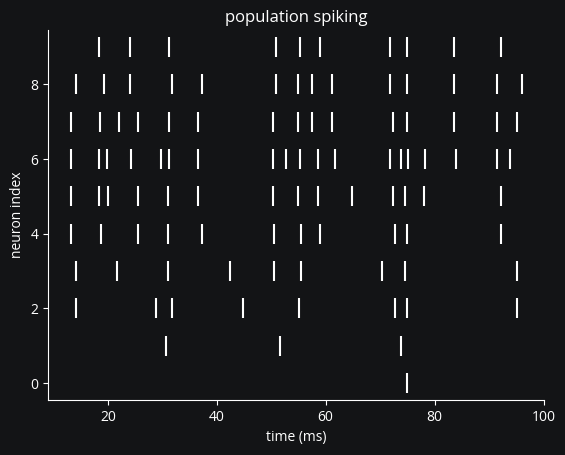

In [ ]:
fig, ax = plt.subplots()
ax.scatter(pop_mon.t / ms, pop_mon.i, marker="|", c="w", s=200)
ax.set(title="population spiking", ylabel="neuron index", xlabel="time (ms)");

## Constructing a closed-loop simulation

We will use the popular model-free PI control to control a single neuron's firing rate. PI stands for proportional-integral, referring to a feedback gain *proportional* to the instantaneous error as well as the *integrated* error over time.

First we construct a `CLSimulator` from the network:

In [ ]:
sim = cleo.CLSimulator(net)

Then, to control neuron $i$, we need to:
1. capture spiking using a `GroundTruthSpikeRecorder`

In [ ]:
i = 0  # neuron to control
rec = cleo.recorders.GroundTruthSpikeRecorder(name="spike_rec")
sim.inject(rec, population[i])

CLSimulator(io_processor=None, devices={GroundTruthSpikeRecorder(name='spike_rec', save_history=True, _mon=<SpikeMonitor, recording from 'spikemonitor_1'>, _num_spikes_seen=0, neuron_group=<Subgroup 'neurongroup_subgroup' of 'neurongroup' from 0 to 1>)})

2. define the firing rate trajectory we want our target neuron to follow

In [ ]:
# the target firing rate trajectory, as a function of time
def target(t):
    a = 200
    sinusoid = a + a * np.sin(2 * np.pi * 20 * b2.Hz * t)
    out_Hz = 400 * (t < 250 * ms) + sinusoid * (t >= 250 * ms)
    return np.squeeze(out_Hz) * b2.Hz

2. estimating its firing rate from incoming spikes using :func:`~cleo.ioproc.exp_firing_rate_estimate`
3. compute the stimulus intensity with :func:`~cleo.ioproc.pi_ctrl`
4. output that value for a :class:`~cleo.stimulators.StateVariableSetter` stimulator to use

Here we initialize needed variables when the `IOProcessor` is created and define how to process network output and set the control signal in the `process` function.
Here we initialize parameters and state variables needed from call to call.
The `reset()` function of the `IOProcessor` is called automatically on :meth:`cleo.CLSimulator.reset` and should be used to reset the state of the `IOProcessor` to its initial state.

In [ ]:
from cleo.ioproc import LatencyIOProcessor, exp_firing_rate_estimate, pi_ctrl


class PIRateIOProcessor(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)
        # for firing rate estimation
        self.fr_est_tau = 15 * ms

        # error will be in frequency units (firing rate)
        self.Kp = 0.005 / b2.Hz
        # integral error will have no unit (frequency times time)
        self.Ki = 0.04 / (b2.Hz * b2.second)

        self.delay = 7 * ms

        # initializes variables
        self.reset()

    def process(self, state_dict, t_samp):
        spikes = state_dict["spike_rec"]
        prev_rate = self.fr_estimates[-1] if len(self.fr_estimates) > 0 else 0
        fr = exp_firing_rate_estimate(
            spikes, self.sample_period, prev_rate, self.fr_est_tau
        )
        self.fr_estimates.append(fr)

        ctrl_signal, self.int_error = pi_ctrl(
            measurement=fr,
            reference=target(t_samp),
            integ_error=self.int_error,
            dt=self.sample_period,
            Kp=self.Kp,
            Ki=self.Ki,
        )

        # this dictionary output format allows for the flexibility
        # of controlling multiple stimulators
        # limit to positive current
        ctrl_signal = ctrl_signal * (ctrl_signal > 0)
        # grab just first element from 1-length sequence
        # since StateVariableSetter only takes a scalar
        ctrl_signal = ctrl_signal[0]
        out_dict = {"I_stim": ctrl_signal}

        # simulate delayed control by adding to the output time
        out_time = t_samp + self.delay
        return out_dict, out_time

    def reset(self):
        self.fr_estimates = []
        self.int_error = 0


io_processor = PIRateIOProcessor()
sim.set_io_processor(io_processor)

CLSimulator(io_processor=PIRateIOProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={GroundTruthSpikeRecorder(name='spike_rec', save_history=True, _mon=<SpikeMonitor, recording from 'spikemonitor_1'>, _num_spikes_seen=0, neuron_group=<Subgroup 'neurongroup_subgroup' of 'neurongroup' from 0 to 1>)})

Here we simply added a constant delay at the end, but in a complex, multi-step computation, we could add a probabilistic delay for each step to better approximate a real-world latency distribution.

Now we inject the stimulator:

In [ ]:
stim = cleo.stimulators.StateVariableSetter(
    name="I_stim", variable_to_ctrl="I", unit=b2.nA
)
sim.inject(stim, population[i])

CLSimulator(io_processor=PIRateIOProcessor(sample_period=1. * msecond, sampling='fixed', processing='parallel'), devices={GroundTruthSpikeRecorder(name='spike_rec', save_history=True, _mon=<SpikeMonitor, recording from 'spikemonitor_1'>, _num_spikes_seen=0, neuron_group=<Subgroup 'neurongroup_subgroup' of 'neurongroup' from 0 to 1>), StateVariableSetter(name='I_stim', save_history=True, value=0, variable_to_ctrl='I', unit=namp, neuron_groups=[<Subgroup 'neurongroup_subgroup_1' of 'neurongroup' from 0 to 1>])})

## Run the simulation

In [ ]:
sim.run(300 * ms)

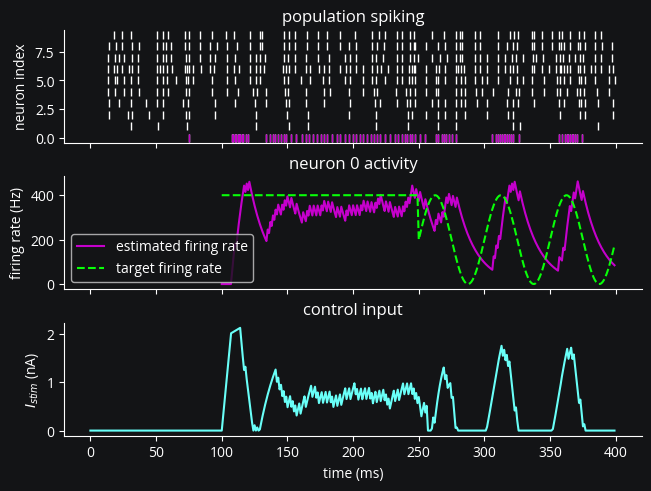

In [ ]:
def plot_results():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, layout="compressed")
    ax1.plot(pop_mon.t / ms, pop_mon.i, "|", c="w")
    ax1.plot(
        pop_mon.t[pop_mon.i == i] / ms,
        pop_mon.i[pop_mon.i == i],
        "|",
        c=c["main"],
    )
    ax1.set(title="population spiking", ylabel="neuron index")

    ax2.plot(
        io_processor.t_samp / ms,
        io_processor.fr_estimates,
        c=c["main"],
    )
    ax2.plot(
        io_processor.t_samp / ms,
        target(io_processor.t_samp),
        c="xkcd:fluorescent green",
        linestyle="--",
    )

    ax2.set(ylabel="firing rate (Hz)", title=f"neuron {i} activity")
    ax2.legend(["estimated firing rate", "target firing rate"])
    ax3.plot(
        stim.t / ms,
        stim.values,
        c=c["accent_light"],
    )
    ax3.set(title="control input", ylabel="$I_{stim}$ (nA)", xlabel="time (ms)")


plot_results()

Note the lag in keeping up with the target firing rate, which can be directly attributed to the ~7 ms delay we coded in to the IO processor.
Let's compare to the result with a short delay.
We can use :meth:`~cleo.CLSimulator.reset` to reset the simulation back to the last time we changed it (in this case when we injected the stimulator).

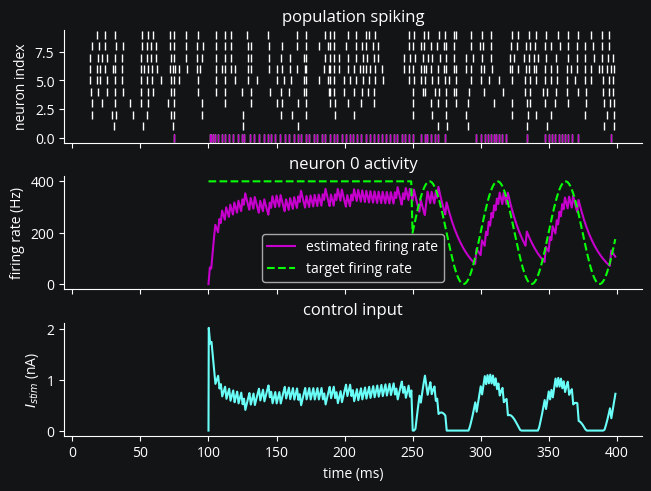

In [ ]:
sim.reset()
io_processor.delay = 0.1 * ms
sim.run(300 * ms)
plot_results()


## Conclusion
In this tutorial, we've learned how to
* use :func:`~cleo.ioproc.pi_ctrl` to interact with a Brian simulation,
* estimate firing rate with :func:`~cleo.ioproc.exp_firing_rate_estimate`, and
* introduce delay to the control output to model real-life latency. 